In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import datasets
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Dense, Dropout, Input
from keras import optimizers, Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import numpy as np

In [2]:
import os

결과보고서
1. 설계한 DNN, 1D-CNN으로 최종 test 데이터에 대해서 "1.6 MSE" 값 도출
2. 데이터가 20개 밖에 되지 않아서 원활한 학습을 위해 아래의 방법 사용;
  1. train,test로 데이터 나눈후 중복 추가생성
  2. 모델 경량화
    - 데이터가 워낙 적어 underfitting이 일어나기 때문에 규제 방법 다 제거
    - 모델 layer는 깊지 않게 설계


## 1. Data 확인하기


In [219]:
from sklearn.datasets import load_linnerud

linnerud = load_linnerud()

In [222]:
df = pd.concat([pd.DataFrame(linnerud.data, columns=linnerud.feature_names),
                pd.DataFrame(linnerud.target, columns=linnerud.target_names)],
               axis=1)
df.head()

,Chins,Situps,Jumps,Weight,Waist,Pulse
0,5.0,162.0,60.0,191.0,36.0,50.0
1,2.0,110.0,60.0,189.0,37.0,52.0
2,12.0,101.0,101.0,193.0,38.0,58.0
3,12.0,105.0,37.0,162.0,35.0,62.0
4,13.0,155.0,58.0,189.0,35.0,46.0


In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Chins   20 non-null     float64
 1   Situps  20 non-null     float64
 2   Jumps   20 non-null     float64
 3   Weight  20 non-null     float64
 4   Waist   20 non-null     float64
 5   Pulse   20 non-null     float64
dtypes: float64(6)
memory usage: 1.1 KB


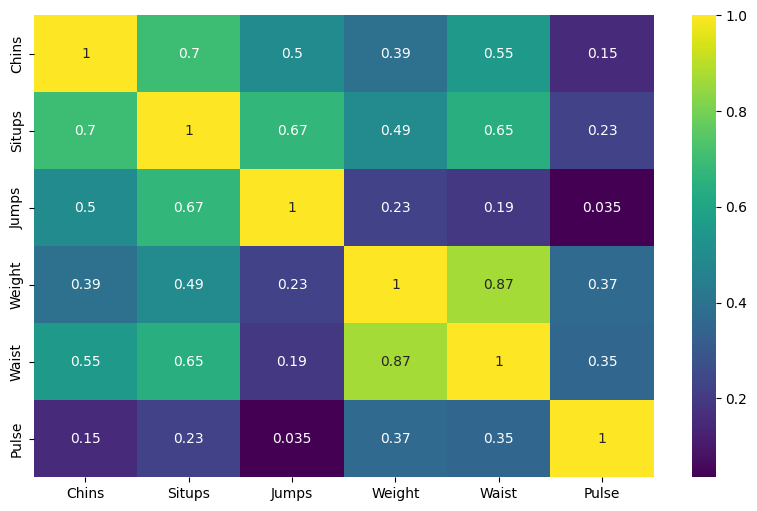

In [224]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(df.corr().abs(), annot=True, cmap="viridis");

## 2. Data preprocessing

In [227]:
df.columns

Index(['Chins', 'Situps', 'Jumps', 'Weight', 'Waist', 'Pulse'], dtype='object')

In [296]:
X = df[['Chins', 'Situps', 'Jumps', 'Weight', 'Waist']].values
Y = df['Pulse'].values

In [297]:
X = np.asarray(X).astype('float32')
Y = np.asarray(Y).astype('float32')
Y = Y[:,np.newaxis]

In [298]:
print(X.min(), X.max())
print(Y.min(), Y.max())

1.0 251.0
46.0 74.0


In [299]:
# from sklearn.preprocessing import MinMaxScaler
# mm = MinMaxScaler()
from sklearn.preprocessing import StandardScaler
mm = StandardScaler()
X_scaled = mm.fit_transform(X)
Y_scaled = mm.fit_transform(Y)

In [300]:
print(X_scaled.min(), X_scaled.max())
print(Y_scaled.min(), Y_scaled.max())

-1.6870744 3.595503
-1.4371493 2.5470269


In [424]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y_scaled, train_size=0.9, random_state=2, shuffle=True)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=2, shuffle=True)

In [425]:
print(x_train.shape, y_train.shape)
# print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(18, 5) (18, 1)
(2, 5) (2, 1)


In [426]:
for _ in range(5):
  x_train=np.concatenate([x_train,x_train], axis=0)
  y_train=np.concatenate([y_train,y_train], axis=0)

  x_test=np.concatenate([x_test,x_test], axis=0)
  y_test=np.concatenate([y_test,y_test], axis=0)

In [427]:
print(x_train.shape, y_train.shape)
# print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(576, 5) (576, 1)
(64, 5) (64, 1)


## 3-1. DNN modeling

In [428]:
# define model params
input_shape = x_train.shape[1]
output_shape = y_train.shape[1]
nodes = np.ceil(2 * input_shape / 3 + output_shape).astype(int)
batch_size = np.ceil(len(x_train) / 128).astype(int)

In [429]:
import tensorflow as tf
from functools import partial

def DNN(input_size=(5,)):
  inputs=Input(input_size)

  # dense1 = Dense(nodes, activation='relu')(inputs)
  # drop1 = Dropout(0.5)(dense1)
  # dense2 = Dense(nodes, activation='relu', kernel_regularizer = regularizer)(drop1)
  # drop2 = Dropout(0.5)(dense2)
  # dense3 = Dense(nodes, activation='relu')(drop2)
  # drop3 = Dropout(0.5)(dense3)

  outputs = Dense(1, activation='sigmoid')(inputs)
  model = Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer='adam', loss='mse', metrics=['mse'])

  return model



In [430]:
DNN_model = DNN()
DNN_model.summary()

Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_50 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_142 (Dense)           (None, 1)                 6         
                                                                 
Total params: 6 (24.00 Byte)
Trainable params: 6 (24.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [431]:
# 모델 컴파일 하기
PATH= "/content/drive/MyDrive/gachon4-2/deeplearning/week2/"
model_checkpoint = ModelCheckpoint(filepath =  os.path.join(PATH,"model.h5"), monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 20)

In [432]:
# 모델 학습
hist = DNN_model.fit(
                  x_train, y_train,                        # 입력 / 라벨
                  epochs = 100, batch_size = batch_size,            # 학습 회수 / 학습 10번 후 오차 감소
                  validation_data=(x_test, y_test),        # 검증 데이터
                  callbacks = [model_checkpoint, early_stopping], # 저장 및 모니터링
                  shuffle=True
                 )



Epoch 1/100
114/116 [============================>.] - ETA: 0s - loss: 1.1676 - mse: 1.1676
Epoch 1: val_loss improved from inf to 1.74272, saving model to /content/drive/MyDrive/gachon4-2/deeplearning/week2/model.h5
116/116 [==============================] - 1s 7ms/step - loss: 1.1674 - mse: 1.1674 - val_loss: 1.7427 - val_mse: 1.7427
Epoch 2/100
100/116 [========================>.....] - ETA: 0s - loss: 1.1146 - mse: 1.1146
Epoch 2: val_loss improved from 1.74272 to 1.71278, saving model to /content/drive/MyDrive/gachon4-2/deeplearning/week2/model.h5
116/116 [==============================] - 0s 3ms/step - loss: 1.1220 - mse: 1.1220 - val_loss: 1.7128 - val_mse: 1.7128
Epoch 3/100
111/116 [===========================>..] - ETA: 0s - loss: 1.0903 - mse: 1.0903
Epoch 3: val_loss improved from 1.71278 to 1.69051, saving model to /content/drive/MyDrive/gachon4-2/deeplearning/week2/model.h5
116/116 [==============================] - 0s 3ms/step - loss: 1.0859 - mse: 1.0859 - val_loss: 1.6

## 4-1. DNN Evaluation

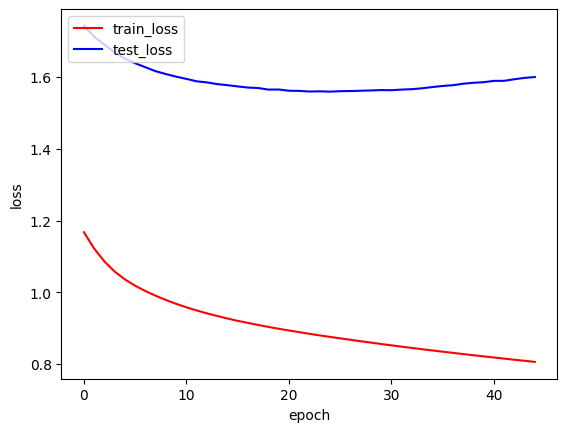

In [433]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], 'r', label = 'train_loss')
plt.plot(hist.history['val_loss'], 'b', label = 'test_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

In [434]:
# 모델 평가
DNN_model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 6ms/step - loss: 1.6003 - mse: 1.6003


[1.6002509593963623, 1.6002509593963623]

1/1 [==============================] - 0s 77ms/step


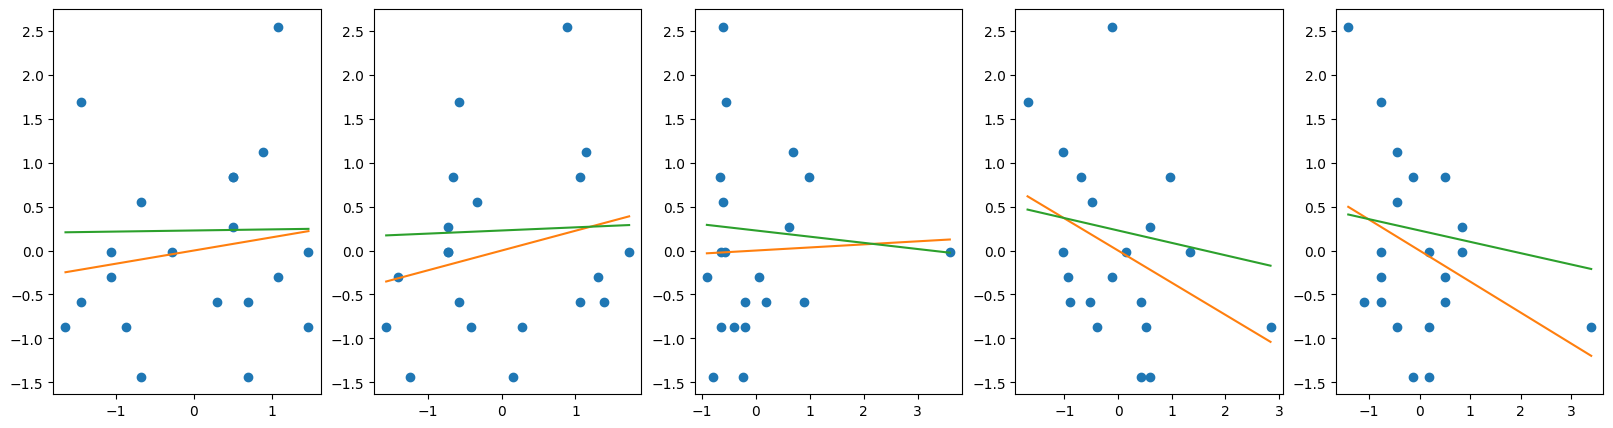

In [435]:
plt.figure(figsize=(20, 5))

inference = DNN_model.predict(X_scaled)[:,0]

for i, x_col in enumerate(X_scaled.transpose(1,0)):
    # 3 plots here hence 1, 3
    plt.subplot(1, 5, i+1)
    x = x_col
    y = Y_scaled[:,0]
    # print(x.shape, y.shape, inference.shape)
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, inference, 1))(np.unique(x)))

## 3-2. 1D-CNN modeling & Train

In [436]:
x_train.shape

(576, 5)

In [437]:
x_train=x_train[:,:,np.newaxis]
# x_val=x_val[:,:,np.newaxis]
x_test=x_test[:,:,np.newaxis]

In [438]:
x_train.shape

(576, 5, 1)

In [454]:

from keras.layers import Dense, Dropout, Input, Conv1D, MaxPooling1D, Flatten
from keras import optimizers, Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

def CNN_1D(input_size=(5,1)):
  inputs=Input(input_size)
  conv = Conv1D(filters=2, kernel_size=2, activation='relu')(inputs)
  flat = Flatten()(conv)

  outputs = Dense(1, activation='sigmoid')(flat)
  model = Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer='adam', loss='mse', metrics=['mse'])

  return model

In [455]:
cnn_model = CNN_1D()
cnn_model.summary()

Model: "model_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, 5, 1)]            0         
                                                                 
 conv1d_25 (Conv1D)          (None, 4, 2)              6         
                                                                 
 flatten_14 (Flatten)        (None, 8)                 0         
                                                                 
 dense_146 (Dense)           (None, 1)                 9         
                                                                 
Total params: 15 (60.00 Byte)
Trainable params: 15 (60.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [456]:
# 모델 컴파일 하기
PATH= "/content/drive/MyDrive/gachon4-2/deeplearning/week2/"
model_checkpoint = ModelCheckpoint(filepath =  os.path.join(PATH,"model.h5"), monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 20)

In [458]:
# 모델 학습
hist = cnn_model.fit(
                  x_train, y_train,                        # 입력 / 라벨
                  epochs = 200, batch_size = batch_size,            # 학습 회수 / 학습 10번 후 오차 감소
                  validation_data=(x_test, y_test),        # 검증 데이터
                  callbacks = [model_checkpoint, early_stopping], # 저장 및 모니터링
                  shuffle=True
                 )


Epoch 1/200
114/116 [============================>.] - ETA: 0s - loss: 0.6925 - mse: 0.6925
Epoch 1: val_loss improved from 1.82226 to 1.81915, saving model to /content/drive/MyDrive/gachon4-2/deeplearning/week2/model.h5
116/116 [==============================] - 1s 6ms/step - loss: 0.6943 - mse: 0.6943 - val_loss: 1.8192 - val_mse: 1.8192
Epoch 2/200
113/116 [============================>.] - ETA: 0s - loss: 0.6901 - mse: 0.6901
Epoch 2: val_loss improved from 1.81915 to 1.81727, saving model to /content/drive/MyDrive/gachon4-2/deeplearning/week2/model.h5
116/116 [==============================] - 1s 6ms/step - loss: 0.6875 - mse: 0.6875 - val_loss: 1.8173 - val_mse: 1.8173
Epoch 3/200
112/116 [===========================>..] - ETA: 0s - loss: 0.6880 - mse: 0.6880
Epoch 3: val_loss improved from 1.81727 to 1.81365, saving model to /content/drive/MyDrive/gachon4-2/deeplearning/week2/model.h5
116/116 [==============================] - 1s 6ms/step - loss: 0.6813 - mse: 0.6813 - val_loss:

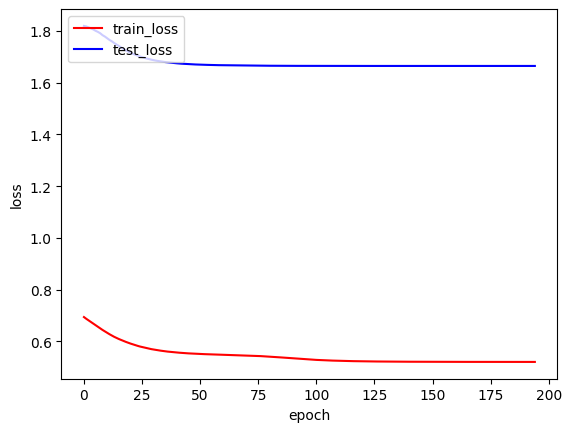

In [461]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], 'r', label = 'train_loss')
plt.plot(hist.history['val_loss'], 'b', label = 'test_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

## 4-2. 1D-CNN Evaluation

1/1 [==============================] - 0s 22ms/step


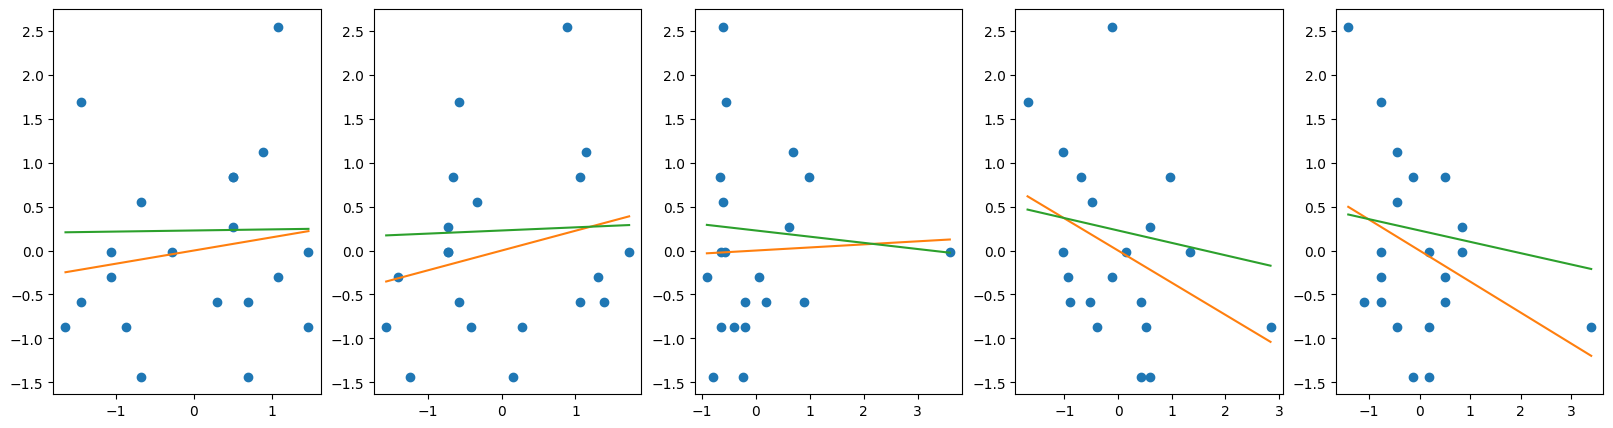

In [462]:
# 모델 평가
cnn_model.evaluate(x_test, y_test)

plt.figure(figsize=(20, 5))
inference = DNN_model.predict(X_scaled)[:,0]

for i, x_col in enumerate(X_scaled.transpose(1,0)):
    # 3 plots here hence 1, 3
    plt.subplot(1, 5, i+1)
    x = x_col
    y = Y_scaled[:,0]
    # print(x.shape, y.shape, inference.shape)
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, inference, 1))(np.unique(x)))